In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import soundfile
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import build
from dct import isdct, sdct
from models import *
from train import generate

In [2]:
class DaNet(pl.LightningModule):
    def __init__(self, model_loader, noise=0.0):
        super().__init__()
        self.save_hyperparameters()
        self.model = eval(model_loader)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, aux = batch
        x += torch.randn_like(x) * self.noise
        x_hat = self.forward(x)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

In [3]:
model = DaNet.load_from_checkpoint('lightning_logs/version_5/checkpoints/epoch=49-step=500.ckpt')

In [4]:
x = torch.randn((1, 256, 10))
y = model(x)[0]
print(y.shape)
print(y.std(dim=1))

torch.Size([256, 10])
tensor([0.2644, 0.3284, 0.2230, 0.2118, 0.1733, 0.4347, 0.2921, 0.1564, 0.1611,
        0.1898, 0.1764, 0.2148, 0.3941, 0.4041, 0.2656, 0.0587, 0.1898, 0.3443,
        0.1465, 0.1838, 0.2809, 0.1214, 0.2321, 0.1132, 0.2063, 0.1356, 0.0606,
        0.2920, 0.2205, 0.4285, 0.1822, 0.1150, 0.2491, 0.2594, 0.2802, 0.3165,
        0.2743, 0.2140, 0.1752, 0.1944, 0.1991, 0.1498, 0.1236, 0.1389, 0.2011,
        0.2410, 0.3474, 0.4386, 0.2149, 0.0730, 0.3056, 0.0719, 0.2009, 0.2034,
        0.1326, 0.1861, 0.1870, 0.1517, 0.1214, 0.2346, 0.0999, 0.1256, 0.0922,
        0.1409, 0.2154, 0.2358, 0.1903, 0.2315, 0.2772, 0.1464, 0.2486, 0.1182,
        0.2672, 0.1606, 0.2441, 0.1016, 0.3654, 0.2066, 0.2946, 0.3613, 0.2029,
        0.1085, 0.3460, 0.2715, 0.1353, 0.2643, 0.2470, 0.3077, 0.1629, 0.3287,
        0.1881, 0.1810, 0.2782, 0.1758, 0.2436, 0.1329, 0.1923, 0.2184, 0.3074,
        0.1118, 0.0544, 0.1749, 0.2858, 0.1580, 0.1116, 0.2779, 0.1292, 0.1562,
        0.4700, 0.

In [9]:
x = generate(model, 10000, show_progress=True)

100%|██████████| 1000/1000 [00:09<00:00, 104.39it/s]


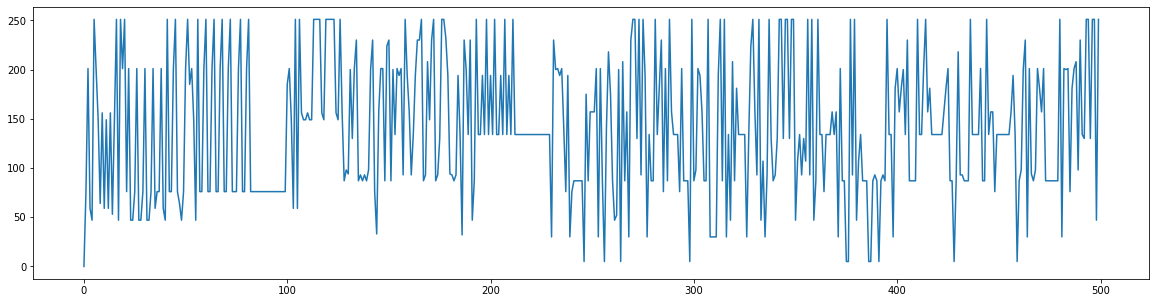

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(x[:, :500].argmax(dim=0))
plt.show()

In [17]:
import build
loader = build.dataloader(data='dataset_v6', part=0.1, batch_size=10, shuffle=True)
t, _ = next(iter(loader))
t = t[0][:, :1000]
t.shape

torch.Size([256, 1000])

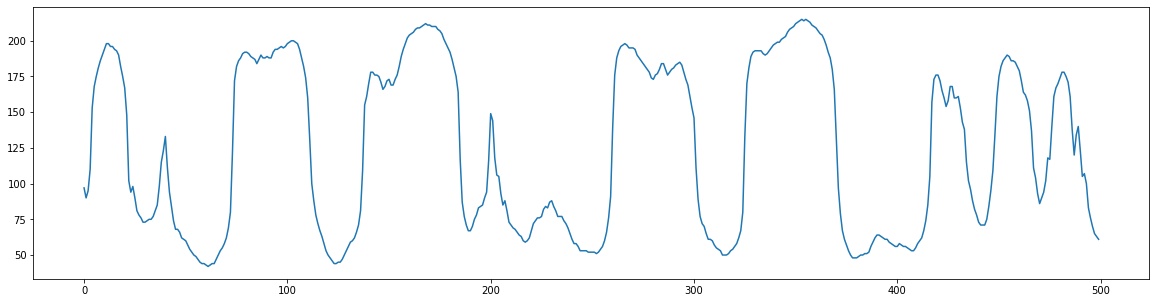

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(t[:, :500].argmax(dim=0))
plt.show()

In [34]:
buffer = t[:, :500]
for i in range(10):
    buffer = torch.cat((buffer, torch.zeros((256, 1))), dim=1)
    predict = model(buffer.unsqueeze(0))[0, :, -1]
    prob = F.softmax(predict, dim=0).detach()
    nxt = t[:, 500 + i].argmax()
    idx = predict.argmax()
    print(nxt, predict[nxt].item(), prob[nxt].item(), predict.min().item(), predict.max().item())
    print(idx, predict[idx].item(), prob[idx].item(), prob.min(), prob.max(), prob.sum())
    print('###')

tensor(58) -3.666727304458618 0.004618810024112463 -5.0103888511657715 -3.0276827812194824
tensor(107) -3.0276827812194824 0.008751118555665016 tensor(0.0012) tensor(0.0088) tensor(1.)
###
tensor(58) -4.433168888092041 0.0022382671013474464 -4.983039855957031 -2.901311159133911
tensor(30) -2.901311159133911 0.0103559335693717 tensor(0.0013) tensor(0.0104) tensor(1.)
###
tensor(57) -3.953265428543091 0.003687845775857568 -5.0551676750183105 -2.9070982933044434
tensor(30) -2.9070982933044434 0.010498261079192162 tensor(0.0012) tensor(0.0105) tensor(1.)
###
tensor(57) -4.06594705581665 0.003680064342916012 -5.219407558441162 -2.9784507751464844
tensor(30) -2.9784507751464844 0.0109181497246027 tensor(0.0012) tensor(0.0109) tensor(1.0000)
###
tensor(58) -4.592348098754883 0.002100534038618207 -5.167184829711914 -2.971008062362671
tensor(30) -2.971008062362671 0.010628420859575272 tensor(0.0012) tensor(0.0106) tensor(1.)
###
tensor(60) -3.8564000129699707 0.004266558680683374 -5.11802101135